In [2]:
%pip install -qr requirements.txt  # install
# %pip install wandb

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ml-kernel 0.0.1 requires setuptools<=51.0.0, but you have setuptools 67.8.0 which is incompatible.
tensorflow 2.6.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.0 requires wrapt~=1.12.1, but you have wrapt 1.15.0 which is incompatible.
cloud-ml 0.0.1 requires requests<=2.25.1,>=2.22.0, but you have requests 2.30.0 which is incompatible.
cloud-ml 0.0.1 requires tqdm<=4.54.1,>=4.45.0, but you have tqdm 4.65.0 which is incompatible.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


### Обучение на задачу детекции лиц

#### Предобработка

http://shuoyang1213.me/WIDERFACE/

In [42]:
!chmod +rwx Untitled.ipynb

In [12]:
!mkdir content

In [14]:
!unzip -qx WIDER_train.zip -d content
!unzip -qx WIDER_val.zip -d content
!unzip -qx wider_face_split.zip -d content

In [63]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob as g
import cv2
from tqdm.notebook import tqdm
from shutil import copy, move

In [51]:
# Val Dataset
new_imgs_dir = 'content/newDataset/images/val'
new_lbls_dir = 'content/newDataset/labels/val'
label_text_name = 'content/wider_face_split/wider_face_val_bbx_gt.txt'
imgs_address = 'content/WIDER_val/images'

os.makedirs(new_imgs_dir,exist_ok = True, mode=777)
os.makedirs(new_lbls_dir,exist_ok = True, mode=777)
annots = open(label_text_name) 
lines = annots.readlines()
names =   [x for x in lines if 'jpg' in x]
indices = [lines.index(x) for x in names]
!chmod +rwx 'content/newDataset/images/val'
!chmod +rwx 'content/newDataset/labels/val'

for n in tqdm(range(len(names[:]))):
    i = indices[n]
    name = lines[i].rstrip()
    old_img_path = os.path.join(imgs_address , name)
    name = name.split('/')[-1]
    label_path = os.path.join(new_lbls_dir , name.split('.')[0] + '.txt')
    img_path = os.path.join(new_imgs_dir , name)
    
    num_objs = int(lines[i+1].rstrip())
    bboxs = lines[i+2 : i+2+num_objs]
    bboxs = list(map(lambda x:x.rstrip() , bboxs))
    bboxs = list(map(lambda x:x.split()[:4], bboxs))
    # if len(bboxs) > 5:
    #     continue
    img = cv2.imread(old_img_path)
    img_h,img_w,_ = img.shape
    img_h,img_w,_ = img.shape
    f = open(label_path, 'w+')
    count = 0 # Num of bounding box
    for bbx in bboxs:
        x1 = int(bbx[0])
        y1 = int(bbx[1])
        w = int(bbx[2])
        h = int(bbx[3])
    #     #yolo:
        x = (x1 + w//2) / img_w
        y = (y1 + h//2) / img_h
        w = w / img_w
        h = h / img_h
        if w * h * 100 > 2:
            yolo_line = f'{0} {x} {y} {w} {h}\n'
            f.write(yolo_line)
            count += 1
    f.close()
    if count > 0:   
        copy(old_img_path , img_path)
    else:
        os.remove(label_path)
     

  0%|          | 0/3226 [00:00<?, ?it/s]

In [53]:
# Train Dataset
new_imgs_dir = 'content/newDataset/images/train'
new_lbls_dir = 'content/newDataset/labels/train'
label_text_name = 'content/wider_face_split/wider_face_train_bbx_gt.txt'
imgs_address = 'content/WIDER_train/images'

os.makedirs(new_imgs_dir,exist_ok = True)
os.makedirs(new_lbls_dir,exist_ok = True)
annots = open(label_text_name) 
lines = annots.readlines()
names =   [x for x in lines if 'jpg' in x]
indices = [lines.index(x) for x in names]

!chmod +rwx 'content/newDataset/images/train'
!chmod +rwx 'content/newDataset/labels/train'


for n in tqdm(range(len(names[:]))):
    i = indices[n]
    name = lines[i].rstrip()
    old_img_path = os.path.join(imgs_address , name)
    name = name.split('/')[-1]
    label_path = os.path.join(new_lbls_dir , name.split('.')[0] + '.txt')
    img_path = os.path.join(new_imgs_dir , name)
    num_objs = int(lines[i+1].rstrip())
    bboxs = lines[i+2 : i+2+num_objs]
    bboxs = list(map(lambda x:x.rstrip() , bboxs))
    bboxs = list(map(lambda x:x.split()[:4], bboxs))
    # if len(bboxs) > 5:
    #     continue
    img = cv2.imread(old_img_path)
    img_h, img_w, _ = img.shape
    f = open(label_path, 'w')
    count = 0 # Num of bounding box
    for bbx in bboxs:
        x1 = int(bbx[0])
        y1 = int(bbx[1])
        w = int(bbx[2])
        h = int(bbx[3])
    #     #yolo:
        x = (x1 + w//2) / img_w
        y = (y1 + h//2) / img_h
        w = w / img_w
        h = h / img_h
        if w * h * 100 > 2:
            yolo_line = f'{0} {x} {y} {w} {h}\n'
            f.write(yolo_line)
            count += 1
    f.close()
    if count > 0:   
        copy(old_img_path , img_path)
    else:
        os.remove(label_path)

  0%|          | 0/12880 [00:00<?, ?it/s]

In [54]:
def resize_img(input_name , output_name, target_width = 640):
    im = cv2.imread(input_name)
    h,w,_  = im.shape
    target_height = int(h / w * target_width)
    im = cv2.resize(im , (target_width , target_height), interpolation = cv2.INTER_AREA)
    cv2.imwrite(output_name , im)

def resize_all_imgs(imgs_dir):
    names = g(os.path.join(imgs_dir , '*'))
    for img in tqdm(names):
        resize_img(img, img)

In [56]:
names = g('content/newDataset/labels/*/*')
print(f'Threre are {len(names)}  images')

Threre are 5253  images


In [57]:
resize_all_imgs('content/newDataset/images/*')

  0%|          | 0/5253 [00:00<?, ?it/s]

In [58]:
n = np.random.randint(0, len(names))
f = open(names[n])

lines = f.readlines()

In [59]:
lines

['0 0.224609375 0.270979020979021 0.0791015625 0.2534965034965035\n']

number of bounding boxes : 1
Shape on the image : (436, 640, 3)


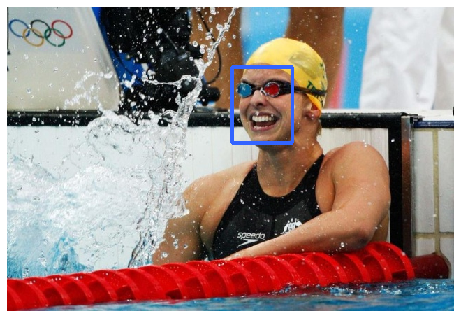

In [60]:
n = np.random.randint(0, len(names))
f = open(names[n])

lines = f.readlines()
classes = list(map(lambda x: int(x[0]), lines))
lines = list(map(lambda x:x.rstrip()[2:], lines))
objects = list(map(lambda x:(x.split()), lines))

img = cv2.imread(names[n].replace('txt','jpg').replace('labels', 'images'))
for c, bbox in zip(classes, objects):
  bbox = list(map(lambda x:float(x), bbox))
  x,y,w,h = bbox
  img_h = img.shape[0]
  img_w = img.shape[1]
  x = int(x * img_w)
  w = int(w * img_w)
  y = int(y * img_h)
  h = int(h * img_h)
  color = (255,100,50)
  cv2.rectangle(img , (int(x-w/2), int(y-h/2)), (int(x+w/2), int(y+h/2)), color , 4)
plt.figure(figsize = (8,8))
plt.imshow(img[:,:,::-1]); plt.axis('off')
print(f'number of bounding boxes : {len(classes)}')
print(f'Shape on the image : {img.shape}')

In [65]:
f = open('content/dataset.yaml', 'w+')
f.write('train: content/newDataset/images/train')
f.write('\nval: content/newDataset/images/val')
f.write('\nnc: {}'.format(1))
f.write("\nnames: ['Face']")

f.close()

In [66]:
#!g1.1
import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-178-ga199480 Python-3.8.12 torch-1.9.1+cu111 CUDA:0 (Tesla V100-PCIE-32GB, 32510MiB)


Setup complete ✅ (8 CPUs, 94.4 GB RAM, 42.0/98.4 GB disk)


In [67]:
#!g1.1
import wandb
wandb.login(key='7ff87162259bed9b4335e8d720503db23ef7f59e')

wandb: Currently logged in as: robasti. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc


True

In [68]:
#!g1.1
wandb.init(project='savchenko')

wandb: Tracking run with wandb version 0.15.4
wandb: Run data is saved locally in /home/jupyter/work/resources/yolov5/wandb/run-20230614_204456-cx2y574b
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run astral-morning-5
wandb: ⭐️ View project at https://wandb.ai/robasti/savchenko
wandb: 🚀 View run at https://wandb.ai/robasti/savchenko/runs/cx2y574b


In [8]:
#!g1.1
!python3 train.py --img 640 --batch 64 --epochs 35\
  --weights yolov5s.pt\
  --cfg models/yolov5s.yaml\
  --data content/dataset.yaml\
  --name yolov5s_finetuned

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: robasti. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=content/dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=35, batch_size=64, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_finetuned, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-178-ga199480 Python-3.8.12 torch-1.9.1+cu111 CU

In [84]:
#!g1.1
# !python3 detect.py --weights 'runs/train/yolov5s_finetuned/weights/best.pt' --img 640 --source 'content/newDataset/images/val'

### Обучение на задачу распознавания вовлеченности

In [81]:
#!g1.1
import torch
import utils
display = utils.notebook_init()  # checks
import wandb
wandb.login(key='7ff87162259bed9b4335e8d720503db23ef7f59e')
wandb.init(project='savchenko')

Setup complete ✅ (8 CPUs, 94.4 GB RAM, 42.0/98.4 GB disk)


YOLOv5 🚀 v7.0-178-ga199480 Python-3.8.12 torch-1.9.1+cu111 CUDA:0 (Tesla V100-PCIE-32GB, 32510MiB)
wandb: Currently logged in as: robasti. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc
wandb: Tracking run with wandb version 0.15.4
wandb: Run data is saved locally in /home/jupyter/work/resources/yolov5/wandb/run-20230615_004325-47od765b
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run worldly-wood-6
wandb: ⭐️ View project at https://wandb.ai/robasti/savchenko
wandb: 🚀 View run at https://wandb.ai/robasti/savchenko/runs/47od765b


In [83]:
#!g1.1
!python3 train.py --img 480 --batch 16 --epochs 300\
  --weights 'runs/train/yolov5s_finetuned/weights/best.pt'\
  --data custom_data_new/dataset.yaml\
  --name yolov5s_myface

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: robasti. Use `wandb login --relogin` to force relogin
train: weights=runs/train/yolov5s_finetuned/weights/best.pt, cfg=, data=custom_data_new/dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=16, imgsz=480, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_myface, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-178-ga199480 Python-3.8.12

In [85]:
#!g1.1
# !python3 detect.py --weights 'runs/train/yolov5s_myface5/weights/best.pt' --img 480 --source 'custom_data/images/val'